# Find cluster related terms using LIME

## Load the data

In [1]:
root_dir = '../..'
data_dir = 'data'
corpus_dir = 'corpus'
src_dir = 'src'

In [2]:
import os 
import sys

In [3]:
sys.path.append(os.path.join(root_dir, src_dir))

In [4]:
dataset_name = 'alaska'
test_name = 'sampling_records_and_terms_test1'

In [5]:
corpus_filename = f'{dataset_name}_corpus.json'
corpus_filepath = os.path.join(root_dir, data_dir, corpus_dir, corpus_filename)

In [6]:
chunks_filename = f'{dataset_name}_chunks.json'
chunks_filepath = os.path.join(root_dir, data_dir, corpus_dir, chunks_filename)

In [7]:
from training import TrainingCorpus

In [8]:
corpus = TrainingCorpus()
corpus.load(corpus_filepath)
corpus.load_chunks(chunks_filepath)

---

## Load the model

In [9]:
from model import TensorflowModel

Using TensorFlow backend.


In [10]:
models_dir = 'models'

In [11]:
model_filename = f'{dataset_name}_nn_model.h5'
model_filepath = os.path.join(root_dir, data_dir, models_dir, model_filename)

In [12]:
word_index_filename = f'{dataset_name}_nn_word_index.csv'
word_index_filepath = os.path.join(root_dir, data_dir, models_dir, word_index_filename)

In [13]:
nn_model = TensorflowModel(model_filepath, word_index_filepath)

/home/nvidia/anaconda3/envs/testenv/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


---

## Sample data

### Load the embedding model

In [14]:
from keras.models import load_model
from keras.models import Model

In [15]:
tf_model = load_model(model_filepath)

First of all we need to load a subset of `tf_model` such that the last layer is the LSTM layer. Using this neural network we can get for each input its corresponding embedding.

In [16]:
print('Index\tLayer')
print('-------------------------')
for index, layer in enumerate(tf_model.layers):
    print(index,'\t',layer.name)

Index	Layer
-------------------------
0 	 input_1
1 	 embedding_1
2 	 bidirectional_1
3 	 dense_1
4 	 dense_2


In [17]:
embedding_model = Model(tf_model.input, tf_model.get_layer(index=2).output)

Plot the model

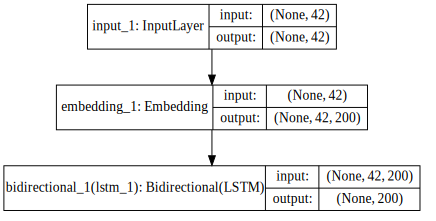

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(embedding_model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

### Retrieve embeddings using the embedding model

In [19]:
import numpy as np
import pandas as pd

In [20]:
word_index_df = pd.read_csv(word_index_filepath, index_col='term')
word_to_idx_map = word_index_df.to_dict()['index']

In [21]:
from keras.preprocessing.sequence import pad_sequences

def tokens_to_sequence(tokens, word_to_idx_map, maxlen):
    sequence = []
    for token in tokens:
        if token in word_to_idx_map:
            token_idx = word_to_idx_map[token]
            sequence.append(token_idx)
    
    padded_sequence = pad_sequences([sequence], maxlen=maxlen).reshape(-1)
    return padded_sequence

Get model input size

In [22]:
maxlen = tf_model.input.shape[1]
maxlen

42

Build the embedding matrix

In [23]:
doc_sequences = []

In [24]:
for doc_id in corpus.docs:
    doc_tokens = corpus.get_tokens(doc_id)
    doc_sequence = tokens_to_sequence(doc_tokens, word_to_idx_map, maxlen)
    doc_sequences.append(doc_sequence)

In [25]:
doc_sequences_np = np.array(doc_sequences)
doc_sequences_np.shape

(2171, 42)

In [26]:
embedding_matrix = embedding_model.predict(doc_sequences_np)
embedding_matrix.shape

(2171, 200)

### Sample documents using K-means

In [27]:
label_to_data_idx_map = nn_model.label_to_data_idx(corpus)

In [28]:
from sample import KMeansSampler

sampler = KMeansSampler(corpus, 
                        embedding_matrix,
                        label_to_data_idx_map,
                        min_size=50,
                        max_size=100)

Utility function used for sampling data for each concept

In [29]:
def sample_data_mp(sampler, label_idx):
    sample_data_idxs = sampler.sample_data(label_idx)
    return (label_idx, sample_data_idxs)

Get the number of available CPU cores

In [30]:
import psutil

In [31]:
psutil.cpu_count(logical=False)

22

Set the number of parallel job for the sampling step

In [32]:
kmeans_jobs = 8

Finally, sample the data

In [33]:
from joblib import Parallel, delayed

In [34]:
label_to_sample_idxs = Parallel(n_jobs=kmeans_jobs, verbose=10)(delayed(sample_data_mp)(sampler, label_idx) for label_idx in label_to_data_idx_map)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    4.4s remaining:    6.6s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    4.5s remaining:    3.7s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    4.7s remaining:    2.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    5.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    5.5s finished


## Find relevant terms for each cluster label using LIME

### Define utility function for multicore processing

In [35]:
from termfinder import LimeTermFinder

In [36]:
def get_relevant_terms_mp(model, corpus, input_data):
    result_list = []
    
    term_finder = LimeTermFinder(model, corpus, min_fts=15, max_fts=30)
    
    for label_idx, data_idx in input_data:
        relevant_terms = term_finder.get_relevant_terms(data_idx, label_idx)
        
        if relevant_terms:
            
            for term, weight in relevant_terms.items():
                dict_entry = {'label': corpus.labels[label_idx],
                              'term': term,
                              'weight': weight,
                              'data_id': corpus.docs[data_idx]}
                result_list.append(dict_entry)
    
    return result_list

### Split the data into multiple batches

In [37]:
input_data = np.array([(label_idx, data_idx) for label_idx, data_idxs in label_to_sample_idxs for data_idx in data_idxs])

Set the number of parallel jobs

In [38]:
lime_jobs = 12

Compute batches

In [39]:
input_slices = np.array_split(input_data, lime_jobs)

Finally, find relevant terms using `LIME`

In [40]:
import time
import datetime

start_time = time.time()
terms_list_tmp = Parallel(n_jobs=lime_jobs, verbose=10, batch_size=1)(delayed(get_relevant_terms_mp)(nn_model, corpus, input_batch) for input_batch in input_slices)

end_time = time.time()

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  6.5min remaining: 19.4min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:  6.5min remaining:  9.1min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:  6.7min remaining:  4.8min
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:  7.2min remaining:  2.4min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  8.9min finished


In [41]:
delta_t = end_time - start_time
elapsed_time = str(datetime.timedelta(seconds=delta_t))
print(f'Elapsed time: {elapsed_time}')

Elapsed time: 0:08:52.414227


Build a DataFrame out of `terms_list_tmp`

In [42]:
df_data = []
for sublist in terms_list_tmp:
    df_data += sublist

In [43]:
df_data[:3]

[{'label': 'ENTITY#44',
  'term': 'nikon_d3200_digital_camera_body',
  'weight': 0.8970025770232101,
  'data_id': 180},
 {'label': 'ENTITY#44',
  'term': 'd3200',
  'weight': 0.4765042327764458,
  'data_id': 73},
 {'label': 'ENTITY#44',
  'term': '24',
  'weight': 0.28851455332782855,
  'data_id': 73}]

In [44]:
relevant_terms_df = pd.DataFrame(df_data)

In [45]:
relevant_terms_df.head()

,label,term,weight,data_id
0,ENTITY#44,nikon_d3200_digital_camera_body,0.897003,180
1,ENTITY#44,d3200,0.476504,73
2,ENTITY#44,24,0.288515,73
3,ENTITY#44,nikon,0.159362,73
4,ENTITY#44,slr,0.114818,73


---

## Save retrieved terms to a file

In [46]:
terms_dir = 'terms'
filename = f'relevant_terms_{dataset_name}_nn_{test_name}.csv'
filepath = os.path.join(root_dir, data_dir, terms_dir, filename)
filepath

'../../data/terms/relevant_terms_alaska_nn_sampling_records_and_terms_test1.csv'

In [47]:
relevant_terms_df.to_csv(filepath, encoding='utf-8', index=False)

---

## Check for pending joblib processes

In [48]:
from multiprocessing import active_children

In [51]:
active_children()

[]

---